Source: https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as pl
import os

In [2]:
df_src = pd.read_csv(pl.Path(os.path.abspath('')).parent.parent.resolve() / "data_files/processed_csv/summarized_corpus_valset2.csv")


In [3]:
df = df_src.copy()
df.head()

,id,domain,type,scraped_at,words,content_len,mean_word_len,median_word_len,split
0,34,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'headlin': 1, 'bitcoin': 1, 'blockchain': 2, ...",1574,5.381743,4.0,3
1,35,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'water': 2, 'cooler': 2, '<number><number><nu...",6647,5.081418,4.0,4
2,36,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'veteran': 2, 'comment': 8, 'call': 5, 'grow'...",3144,4.596525,4.0,7
3,37,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'lost': 6, 'word': 8, 'hidden': 3, 'bank': 4,...",3587,4.348983,4.0,8
4,39,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'scientist': 13, 'move': 11, 'doomsday': 19, ...",17970,5.380292,5.0,10


In [5]:
df.type.value_counts()

reliable    1530555
fake         715808
Name: type, dtype: int64

In [4]:
# remove duplicates by only keeping first occurence
df = df[df.duplicated(subset=["domain","type","scraped_at","words","content_len","mean_word_len"], keep='first') == False]

In [5]:
df = df.drop(["domain", "scraped_at"], axis = 1)

In [6]:
df.type.value_counts()

reliable    1525234
fake         619473
Name: type, dtype: int64

In [7]:
fake = "fake"
real = "reliable"
df = df[(df.type == fake) | (df.type == real)]
df.isnull().sum()

id                 0
type               0
words              0
content_len        0
mean_word_len      0
median_word_len    0
split              0
dtype: int64

In [8]:
# Shuffling
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(["index"], axis=1, inplace=True)

In [108]:
# df reduction to 200.000 articles; approx 1/10th
df2 = df[0:200_000]

<Axes: xlabel='type', ylabel='count'>

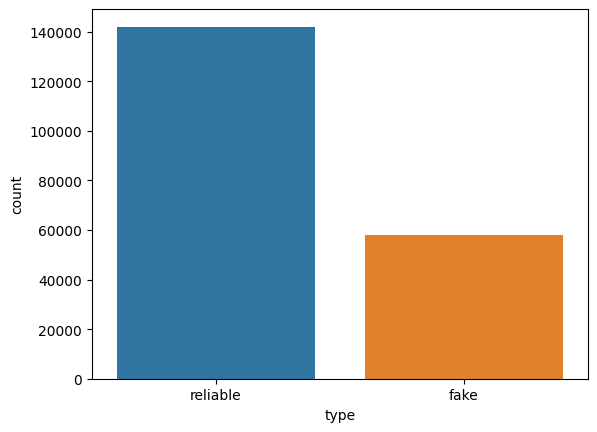

In [109]:
sns.countplot(data=df2,
              x='type',
              order=df2['type'].value_counts().index)

### Preprocessing and analysis of News column

In [110]:
import ast
print(type(df2.words[0]))
df2['words'] = df2['words'].apply(ast.literal_eval)
print(type(df2.words[0]))

<class 'str'>
<class 'dict'>


C:\Users\45609\AppData\Local\Temp\ipykernel_27212\1432465424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['words'] = df2['words'].apply(ast.literal_eval)


In [50]:
# Use DictVectorizer to transform bag_of_words column
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()

D = df2['words']
bag_of_words_matrix = vectorizer.fit_transform(D)

In [51]:
bag_of_words_matrix

<20000x13675 sparse matrix of type '<class 'numpy.float64'>'
	with 3409732 stored elements in Compressed Sparse Row format>

In [52]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()
feature_names[4340:4360]

array(['farfetch', 'farflung', 'fargo', 'farley', 'farm', 'farmer',
       'farmhous', 'farmingdal', 'farmland', 'farrar', 'farreach',
       'farrel', 'farright', 'farther', 'fascin', 'fascism', 'fascist',
       'fashion', 'faso', 'fassel'], dtype=object)

In [53]:
# Convert matrix to dataframe
bag_of_words_df = pd.DataFrame.sparse.from_spmatrix(bag_of_words_matrix, columns=feature_names)

In [54]:
# Concatenate article_id column and bag_of_words_df
result = pd.concat([df2['id'],df2['type'],df2['content_len'], bag_of_words_df], axis=1)

In [55]:
result

,id,type,content_len,+,00,000,0000,0000a,0000b,000k,...,zone,zoo,zucchini,zucker,zuckerberg,zuma,zurich,|,||,~
0,9292489,reliable,2312,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9441160,reliable,12634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8660443,reliable,1349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5999415,fake,1771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4593771,fake,700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8998900,reliable,2406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,8870869,reliable,4095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,6361465,fake,3484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,9075674,reliable,2642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Converting text into Vectors
Before converting the data into vectors, split it into train and test.

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
  
x_train, x_test, y_train, y_test = train_test_split(df2['words'], 
                                                    df2['type'], 
                                                    test_size=0.20)

In [112]:
x_train.head()

127681    {'democrat': 3, 'request': 2, 'million': 4, 'c...
124109    {'photo': 1, 'kansa': 4, 'west': 4, 'virginia'...
35527     {'editor': 1, 'just': 2, 'return': 2, 'twoweek...
49865     {'d': 1, 'uniqu': 1, 'man': 1, 'today': 1, 'bi...
30273     {'best': 1, 'seller': 1, 'these': 1, 'list': 1...
Name: words, dtype: object

In [113]:
vectorizer = DictVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)  

### Model training, Evaluation, and Prediction
Now, the dataset is ready to train the model.

For training we will use Naive Bayes and evaluate the prediction accuracy using accuracy_score.

### Multinominal Naive Bayes Model
In spite of their apparently over-simplified assumptions, naive Bayes classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. They require a small amount of training data to estimate the necessary parameters.
Source: Sci-kit learn https://scikit-learn.org/stable/modules/naive_bayes.html

In [143]:
from sklearn.metrics import f1_score, balanced_accuracy_score as bas
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1, force_alpha=True)
mnb.fit(x_train, y_train)
print(mnb.predict(x_train[1:2]))

# testing the model
print(accuracy_score(y_train, mnb.predict(x_train)))
print(accuracy_score(y_test, mnb.predict(x_test)))
print(f1_score(y_test, mnb.predict(x_test), average="weighted"))
print(bas(y_test, mnb.predict(x_test)))

['reliable']
0.87753125
0.8757
0.8784924073689577
0.876725426433417


The confusion matrix for Naive Bayes can be implemented with the code below.

In [141]:
from sklearn.metrics import f1_score, balanced_accuracy_score as bas
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB(alpha=1, force_alpha=True)
cnb.fit(x_train, y_train)
print(cnb.predict(x_train[1:2]))

# testing the model
print(accuracy_score(y_train, cnb.predict(x_train)))
print(accuracy_score(y_test, cnb.predict(x_test)))
print(f1_score(y_test, cnb.predict(x_test), average="weighted"))
print(bas(y_test, cnb.predict(x_test)))

['reliable']
0.87465625
0.87295
0.8762125202887393
0.8784115250286653


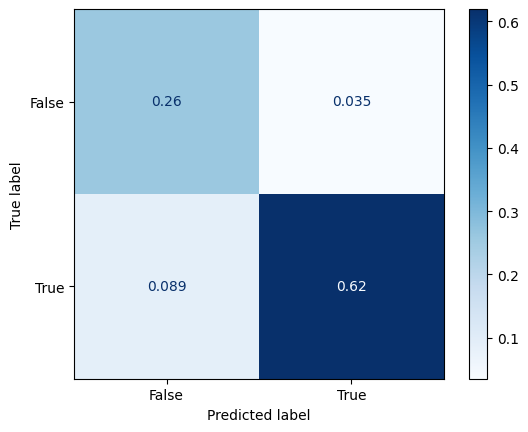

In [124]:
# Confusion matrix of Results from Multinominal Naive Bayes (mnb)
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, mnb.predict(x_test), normalize="all")
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot(cmap="Blues")
plt.show()

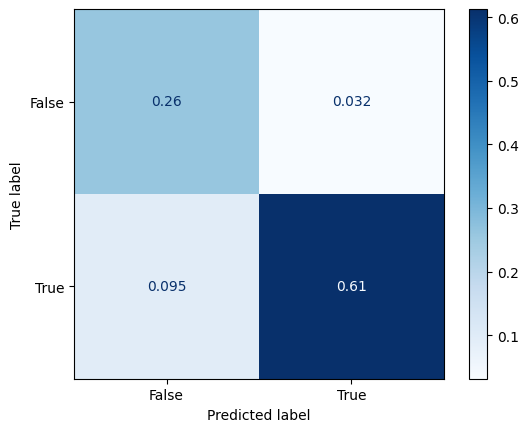

In [123]:
# Confusion matrix of Results from Complement Naive Bayes (cnb)
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, cnb.predict(x_test), normalize="all")
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot(cmap="Blues")
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

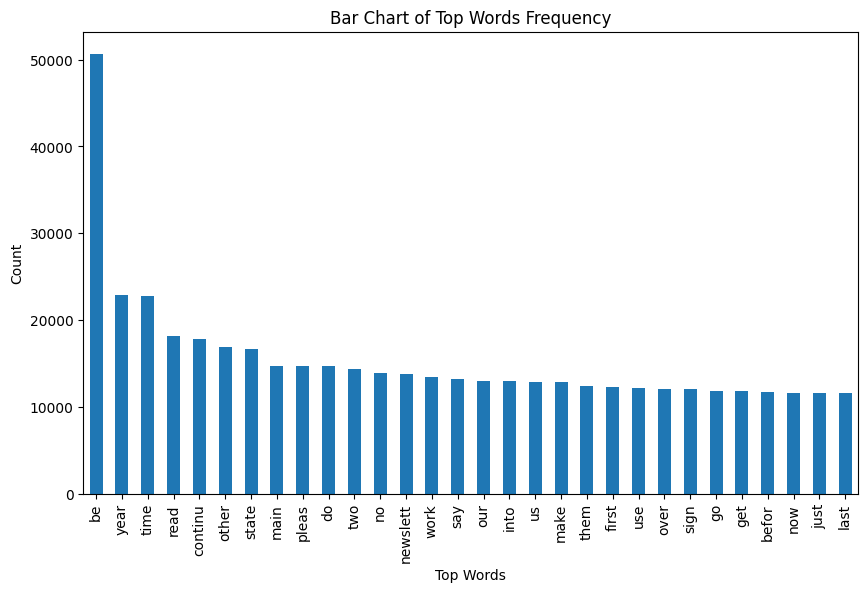

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
  
  
def get_top_n_words(corpus, n=None):
    vec = DictVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(df2['words'].tolist(), 30)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)